# Load our video file into memory

Welcome to foosbot

In [1]:
#!pip install keras
#!pip install numpy
#!pip install imageio
#!pip install matplotlib
#!pip install opencv-python

In [1]:
from __future__ import print_function


from video_file import *

import importlib
try:
    importlib.reload(video_file)
except:
    pass

import cv2
import sys
import os
import csv
import numpy as np
from random import randint
from random import shuffle

from PIL import Image
import imageio
import itertools as it

import tensorflow as tf
import keras
print("Keras version %s" % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

print("Tensorflow version %s" % tf.__version__)

import pprint
pp = pprint.PrettyPrinter(depth=6)


# Create the image transformer
transformer = VideoTransform( zoom_range=0.1, rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, shear_range= 0.1, fill_mode='nearest', vertical_flip=False, horizontal_flip=False, horizontal_flip_invert_indices = [], horizontal_flip_reverse_indices = [0,1,2,3,4,5], data_format='channels_last' )

# Paths relative to current python file.
data_path  = ".\\..\\..\\TrainingData\\Processed\\AmateurDefender\\Result\\settings.tsv"

print("Opening training frames from config %s." % (data_path))
position_rel_indexes = [0, 5] # Predict current rod positions and future position in 2 frames
frame_rel_indexes = [0] # Use only current frame as input
training = TrainingInput(transformer, data_path, position_rel_indexes, frame_rel_indexes, 0.2)
training.clear_memory()


Using TensorFlow backend.


Keras version 2.0.4
Tensorflow version 1.1.0
Opening training frames from config .\..\..\TrainingData\Processed\AmateurDefender\Result\settings.tsv.
Creating training chunk from .\..\..\TrainingData\Processed\AmateurDefender\Result\chunk0.avi
.\..\..\TrainingData\Processed\AmateurDefender\Result\chunk0.avi
added 15932 new frames for a total of 15932
Creating training chunk from .\..\..\TrainingData\Processed\AmateurDefender\Result\chunk1.avi
.\..\..\TrainingData\Processed\AmateurDefender\Result\chunk1.avi
added 22943 new frames for a total of 38875


In [2]:
# Define our training and validation iterators

image_height       = training.height
image_width        = training.width
image_depth        = training.depth
image_channels     = training.channels
output_size        = 3


def TrainGen():
    while True:
        #print("TrainGen restarting training input.")
        training.move_first_training_frame()
        (frames, output) = training.get_next_training_frame()
        while frames is not None:
            yield (frames, output)
            (frames, output) = training.get_next_training_frame()
            
def ValidateGen():
    while True:
        #print("Validation restarting training input.")
        training.move_first_validation_frame()
        (frames, output) = training.get_next_validation_frame()
        while frames is not None:
            yield (frames, output)
            (frames, output) = training.get_next_validation_frame()

# Generators for training the position
def TrainBatchGen(batch_size):
    gen = TrainGen()
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, image_depth, image_height, image_width, image_channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 3), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            batch_outputs[i,:] = output[0:3] # Train just the 3 current rod positions as outputs
            #batch_outputs[i,:] = output[3:6] - output[0:3] # Train the difference in the three rod positions as output
            #batch_outputs[i,:] = output
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")

def ValidateBatchGen(batch_size):
    gen = ValidateGen()
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, image_depth, image_height, image_width, image_channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 3), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            batch_outputs[i,:] = output[0:3] # Train just the 3 current rod positions as outputs
            #batch_outputs[i,:] = output[3:6] - output[0:3] # Train the difference in the three rod positions as output
            #batch_outputs[i,:] = output
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")
            
# Generators for training the difference in position
def TrainBatchGenDpos(batch_size):
    gen = TrainGen()
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, image_depth, image_height, image_width, image_channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 3), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            #batch_outputs[i,:] = output[0:3] # Train just the 3 current rod positions as outputs
            batch_outputs[i,0] = output[3] - output[0] # Train the difference in the three rod positions as output
            batch_outputs[i,1] = output[4] - output[1]
            batch_outputs[i,2] = output[5] - output[2]
            #batch_outputs[i,:] = output
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")

def ValidateBatchGenDpos(batch_size):
    gen = ValidateGen()
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, image_depth, image_height, image_width, image_channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 3), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            #batch_outputs[i,:] = output[0:3] # Train just the 3 current rod positions as outputs
            batch_outputs[i,0] = output[3] - output[0] # Train the difference in the three rod positions as output
            batch_outputs[i,1] = output[4] - output[1]
            batch_outputs[i,2] = output[5] - output[2]
            #batch_outputs[i,:] = output
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")


# Helper function to plot our validation result
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import pandas as pd
%matplotlib inline


def plot_validate(model, frames, output_true, name):
    #(frames, outputs_true) = next(ValidateBatchGen(2000))
    #frames = np.squeeze(frames, axis=(1,))
    #validate_in, validate_out
    #frames = validate_in
    #outputs_true =validate_out
    outputs_predicted = model.predict(frames, batch_size=32, verbose=1)
    print("Predicted.")
    
    
    pp.pprint(outputs_true)
    pp.pprint(outputs_predicted)
    
    
    plt.figure(figsize=(8,30))
    count = len(frames)
    
    plt.subplot(611)
    plt.plot(range(count),outputs_true[0:count,0], range(count),outputs_predicted[0:count,0] )
    plt.ylabel("Rod 1: %s" % name)
    plt.title("First 200 output recordings")
    plt.grid(True)
    
    plt.subplot(612)
    plt.plot(range(count),outputs_true[0:count,1], range(count),outputs_predicted[0:count,1] )
    plt.ylabel("Rod 2: %s" % name)
    plt.title("First output recordings")
    plt.grid(True)
    
    plt.subplot(613)
    plt.plot(range(count),outputs_true[0:count,2], range(count),outputs_predicted[0:count,2] )
    plt.ylabel("Rod 3: %s" % name)
    plt.title("First output recordings")
    plt.grid(True)
    
    
    
    plt.figure(figsize=(8,30))
    plt.subplot(611)
    
    true, predicted = zip(*sorted(zip(outputs_true[0:count,0], outputs_predicted[0:count,0])))
    plt.plot(range(count),true, range(count),predicted )
    plt.ylabel("Rod 1: %s" % name)
    plt.title("First 200 output recordings")
    plt.grid(True)
    
    plt.subplot(612)
    true, predicted = zip(*sorted(zip(outputs_true[0:count,1], outputs_predicted[0:count,1])))
    plt.plot(range(count),true, range(count),predicted, marker='.', markersize = 2, linewidth =0.1, markerfacecolor='black')
    plt.ylabel("Rod 2: %s" % name)
    plt.grid(True)
    
    plt.subplot(613)
    true, predicted = zip(*sorted(zip(outputs_true[0:count,2], outputs_predicted[0:count,2])))
    plt.plot(range(count),true, range(count),predicted, marker='.', markersize = 2, linewidth =0.1, markerfacecolor='black')
    plt.ylabel("Rod 3: %s" % name)
    plt.grid(True)
    
    
    plt.show()
          


# Input training frame

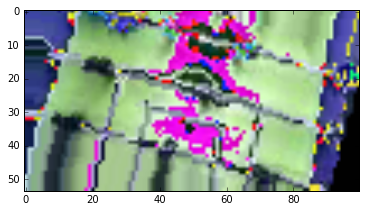

[0.42771084337349397,
 0.2644927536231884,
 0.2192513368983957,
 0.42771084337349397,
 0.2644927536231884,
 0.22459893048128343]


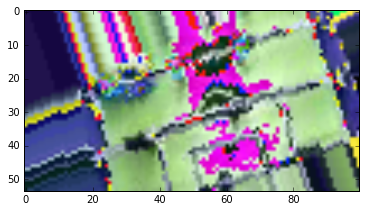

[0.42771084337349397,
 0.2644927536231884,
 0.2192513368983957,
 0.42771084337349397,
 0.2644927536231884,
 0.22459893048128343]


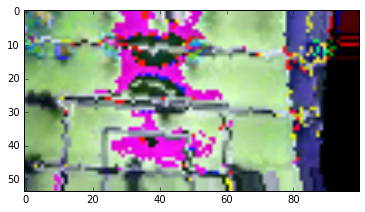

[0.42771084337349397,
 0.2644927536231884,
 0.2192513368983957,
 0.42771084337349397,
 0.2644927536231884,
 0.22459893048128343]


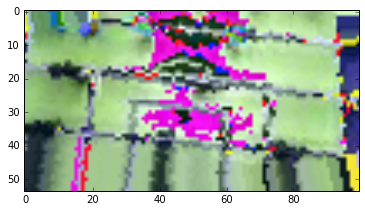

[0.42771084337349397,
 0.2644927536231884,
 0.2192513368983957,
 0.42771084337349397,
 0.2644927536231884,
 0.2192513368983957]


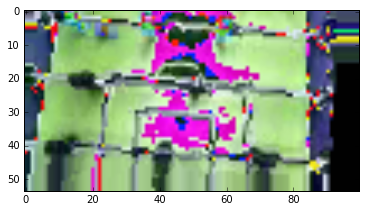

[0.42771084337349397,
 0.2644927536231884,
 0.22459893048128343,
 0.42168674698795183,
 0.2608695652173913,
 0.2192513368983957]


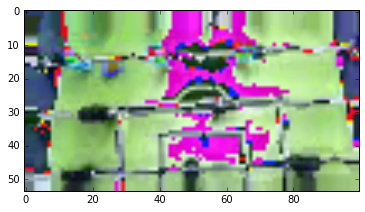

[0.42771084337349397,
 0.2644927536231884,
 0.22459893048128343,
 0.42168674698795183,
 0.2608695652173913,
 0.2192513368983957]


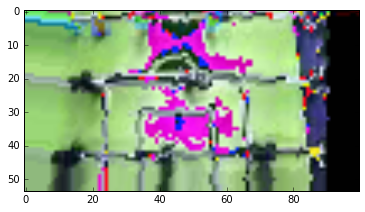

[0.42771084337349397,
 0.2644927536231884,
 0.22459893048128343,
 0.42168674698795183,
 0.2608695652173913,
 0.21390374331550802]


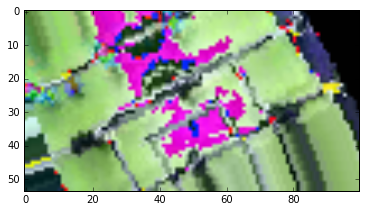

[0.42771084337349397,
 0.2644927536231884,
 0.22459893048128343,
 0.42168674698795183,
 0.2608695652173913,
 0.21390374331550802]


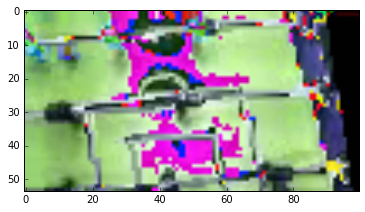

[0.42771084337349397,
 0.2644927536231884,
 0.22459893048128343,
 0.42168674698795183,
 0.2608695652173913,
 0.21390374331550802]


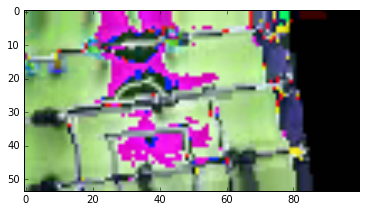

[0.42771084337349397,
 0.2644927536231884,
 0.22459893048128343,
 0.42168674698795183,
 0.2608695652173913,
 0.21390374331550802]
Shape of training input:
(1, 54, 100, 3)
Shape of training output:
(6,)
Corresponding Positions:
[0.42771084337349397,
 0.2644927536231884,
 0.22459893048128343,
 0.42168674698795183,
 0.2608695652173913,
 0.21390374331550802]


In [3]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import pandas as pd
%matplotlib inline

training.move_first_training_frame()

for k in range(10):
    (frame, position) = training.get_next_training_frame()
    data = np.zeros(shape=(np.shape(frame)[1], np.shape(frame)[2] * np.shape(frame)[0], 3), dtype=np.float32)
    for i in range(np.shape(frame)[0]):
        tmp = frame[i,:,:,:]
        data[:,i*np.shape(frame)[2]:(i+1)*np.shape(frame)[2],:] = tmp


    plt.imshow(data)
    plt.show()
    pp.pprint(position)

training.move_first_training_frame()

print("Shape of training input:")
pp.pprint(np.shape(frame))

print("Shape of training output:")
pp.pprint(np.shape(position))

print("Corresponding Positions:")
pd.DataFrame(position)
pp.pprint(position)




# Specify the model structure we will use

In [3]:
from keras.models import Sequential
from keras.layers import *
from keras.models import Model


# Build the model
pp.pprint("Input shape without batches:")
pp.pprint((image_height, image_width, image_channels))


# Build a functional model design
inputs = Input(shape=(1, image_height, image_width, image_channels,))
x = Conv3D(124,
           kernel_size = (1, 5, 5),
           padding = "same")(inputs)
x = Activation('relu')(x)

x = Conv3D(124,
           kernel_size = (1, 5, 5),
           padding = "same")(x)
x = Activation('relu')(x)

# Split into a horizontal detail and vertical detailed CNN paths
x_height_detailed = MaxPooling3D( pool_size=(1, 2, 1))(x) # (?, 1, 54, 100, 128, 3 )

x_height_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_height_detailed)
x_height_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_height_detailed)
x_height_detailed = MaxPooling3D( pool_size=(1, 2, 1))(x_height_detailed)

x_height_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_height_detailed)
x_height_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_height_detailed)
x_height_detailed = MaxPooling3D( pool_size=(1, 2, 1))(x_height_detailed)


x_height_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_height_detailed)
x_height_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_height_detailed)
x_height_detailed = MaxPooling3D( pool_size=(1, 1, 2))(x_height_detailed)

x_height_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_height_detailed)
x_height_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_height_detailed)
x_height_detailed = MaxPooling3D( pool_size=(1, 1, 2))(x_height_detailed)

x_height_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_height_detailed)
x_height_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_height_detailed)
x_height_detailed = MaxPooling3D( pool_size=(1, 1, 2))(x_height_detailed)

x_height_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_height_detailed)
x_height_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_height_detailed)
x_height_detailed = MaxPooling3D( pool_size=(1, 1, 2))(x_height_detailed)


x_height_detailed = Flatten()(x_height_detailed)





x_width_detailed = MaxPooling3D( pool_size=(1, 1, 2))(x) # (?, 1, 54, 100, 128, 3 )

x_width_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_width_detailed)
x_width_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_width_detailed)
x_width_detailed = MaxPooling3D( pool_size=(1, 1, 2))(x_width_detailed)

x_width_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_width_detailed)
x_width_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_width_detailed)
x_width_detailed = MaxPooling3D( pool_size=(1, 1, 2))(x_width_detailed)

x_width_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_width_detailed)
x_width_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_width_detailed)
x_width_detailed = MaxPooling3D( pool_size=(1, 1, 2))(x_width_detailed)

x_width_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_width_detailed)
x_width_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_width_detailed)
x_width_detailed = MaxPooling3D( pool_size=(1, 2, 1))(x_width_detailed)

x_width_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_width_detailed)
x_width_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_width_detailed)
x_width_detailed = MaxPooling3D( pool_size=(1, 2, 1))(x_width_detailed)

x_width_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_width_detailed)
x_width_detailed = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x_width_detailed)
x_width_detailed = MaxPooling3D( pool_size=(1, 2, 1))(x_width_detailed)



x_width_detailed = Flatten()(x_width_detailed)


x = keras.layers.concatenate([x_height_detailed, x_width_detailed])

#x = Flatten()(x_height_detailed)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='linear')(x)

model = Model(inputs=inputs, outputs=predictions)


#epoch = 45
#WEIGHTS_FNAME = 'config5_iter%i.hdf'
#model.load_weights(WEIGHTS_FNAME % epoch)
#print("Loaded model.")

#model.optimizer.lr.assign(0.00000001)

# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),
              loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()

'Input shape without batches:'
(54, 100, 3)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 54, 100, 3) 0                                            
____________________________________________________________________________________________________
conv3d_1 (Conv3D)                (None, 1, 54, 100, 12 9424        input_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 1, 54, 100, 12 0           conv3d_1[0][0]                   
____________________________________________________________________________________________________
conv3d_2 (Conv3D)                (None, 1, 54, 100, 12 384524      activation_1[0][0]               
_______________________________________________

# Train our model to identify the rod positions

In [24]:


def mse(y_true, y_pred):
    return K.square(y_pred - y_true)*0.001 # Hackjob so Keras iterations show exponential value of MSE to get precision.


model.compile(optimizer=keras.optimizers.Adadelta(),
              loss='mean_squared_error',
              metrics=[mse])

print("Updated learner.")

# Train the model to predict the future position. This is the control signal to the robot AI
WEIGHTS_FNAME = 'pos_cnn_weights_%i.hdf'
MODELS_FNAME = 'pos_cnn_models_%i.h5'
for epoch in range(10000):
    try:
        model.fit_generator(TrainBatchGen(20), 1552, epochs=1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(20), validation_steps = 500, pickle_safe=False, initial_epoch=epoch)
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + MODELS_FNAME )  % epoch)
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        break
    

------ Epoch 0 -------
Epoch 1/1
1552/1552 [==============================] - 921s - loss: 0.1677 - acc: 0.3564 - val_loss: 0.0828 - val_acc: 0.4341
------ Epoch 1 -------
Epoch 1/1
1552/1552 [==============================] - 915s - loss: 0.0680 - acc: 0.4360 - val_loss: 0.0626 - val_acc: 0.5147
------ Epoch 2 -------
Epoch 1/1
1552/1552 [==============================] - 915s - loss: 0.0560 - acc: 0.5145 - val_loss: 0.0478 - val_acc: 0.5404
------ Epoch 3 -------
Epoch 1/1
1551/1552 [============================>.] - ETA: 0s - loss: 0.0485 - acc: 0.5591

Exception in thread Thread-183:
Traceback (most recent call last):
  File "C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\threading.py", line 914, in _bootstrap_inner
    self.run()
  File "C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\keras\engine\training.py", line 612, in data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-23-04176765af5b>", line 65, in TrainBatchGen
    (frames, output) = next(gen)
  File "<ipython-input-23-04176765af5b>", line 47, in TrainGen
    (frames, output) = training.get_next_training_frame()
  File "E:\Repos\FoosAI\Code\Training\video_file.py", line 410, in get_next_training_frame
    self.chunks[self.active_chunk].move_first_training_frame()
  File "E:\Repos\FoosAI\Code\Training\video_file.py", line 124, in move_first_training_frame
    self._load_video_memory()
  File "E:\Repos\Foos

1552/1552 [==============================] - 919s - loss: 0.0485 - acc: 0.5591 - val_loss: 0.0435 - val_acc: 0.5336
------ Epoch 4 -------
Epoch 1/1
1552/1552 [==============================] - 913s - loss: 0.0429 - acc: 0.6029 - val_loss: 0.0448 - val_acc: 0.6240
------ Epoch 5 -------
Epoch 1/1
1552/1552 [==============================] - 912s - loss: 0.0391 - acc: 0.6534 - val_loss: 0.0367 - val_acc: 0.5782
------ Epoch 6 -------
Epoch 1/1
1552/1552 [==============================] - 913s - loss: 0.0352 - acc: 0.6837 - val_loss: 0.0262 - val_acc: 0.5457
------ Epoch 7 -------
Epoch 1/1
1552/1552 [==============================] - 913s - loss: 0.0352 - acc: 0.6887 - val_loss: 0.0207 - val_acc: 0.6248
------ Epoch 8 -------
Epoch 1/1
1552/1552 [==============================] - 914s - loss: 0.0320 - acc: 0.7129 - val_loss: 0.0188 - val_acc: 0.5934
------ Epoch 9 -------
Epoch 1/1
1552/1552 [==============================] - 914s - loss: 0.0305 - acc: 0.7236 - val_loss: 0.0157 - val_ac

Exception in thread Thread-201:
Traceback (most recent call last):
  File "C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\threading.py", line 914, in _bootstrap_inner
    self.run()
  File "C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\keras\engine\training.py", line 612, in data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-23-04176765af5b>", line 65, in TrainBatchGen
    (frames, output) = next(gen)
  File "<ipython-input-23-04176765af5b>", line 47, in TrainGen
    (frames, output) = training.get_next_training_frame()
  File "E:\Repos\FoosAI\Code\Training\video_file.py", line 410, in get_next_training_frame
    self.chunks[self.active_chunk].move_first_training_frame()
  File "E:\Repos\FoosAI\Code\Training\video_file.py", line 124, in move_first_training_frame
    self._load_video_memory()
  File "E:\Repos\Foos

1552/1552 [==============================] - 921s - loss: 0.0272 - acc: 0.7448 - val_loss: 0.0176 - val_acc: 0.7743
------ Epoch 13 -------
Epoch 1/1
  54/1552 [>.............................] - ETA: 1012s - loss: 0.0083 - acc: 0.8046

KeyboardInterrupt: 

# Test the best trained model's ability to extract the rod positions

In [19]:

# Load the best model result
epoch = 10
WEIGHTS_FNAME = 'pos_cnn_weights_%i.hdf'
model.load_weights(WEIGHTS_FNAME % epoch)
print("Loaded model.")



Loaded model.


2000/2000 [==============================] - 17s    
Predicted.
array([[ 0.30722892,  0.52536231,  0.58288771],
       [ 0.3253012 ,  0.5289855 ,  0.58288771],
       [ 0.34337351,  0.5289855 ,  0.59893048],
       ..., 
       [ 0.59036142,  0.71376812,  0.07486631],
       [ 0.59036142,  0.71376812,  0.07486631],
       [ 0.57831323,  0.71376812,  0.07486631]], dtype=float32)
array([[ 0.3067027 ,  0.50109524,  0.56606573],
       [ 0.31794617,  0.50979   ,  0.55890185],
       [ 0.33201712,  0.48666403,  0.5880537 ],
       ..., 
       [ 0.60294908,  0.66040409,  0.22253807],
       [ 0.61058378,  0.66041636,  0.21468252],
       [ 0.60112321,  0.67395008,  0.21443769]], dtype=float32)


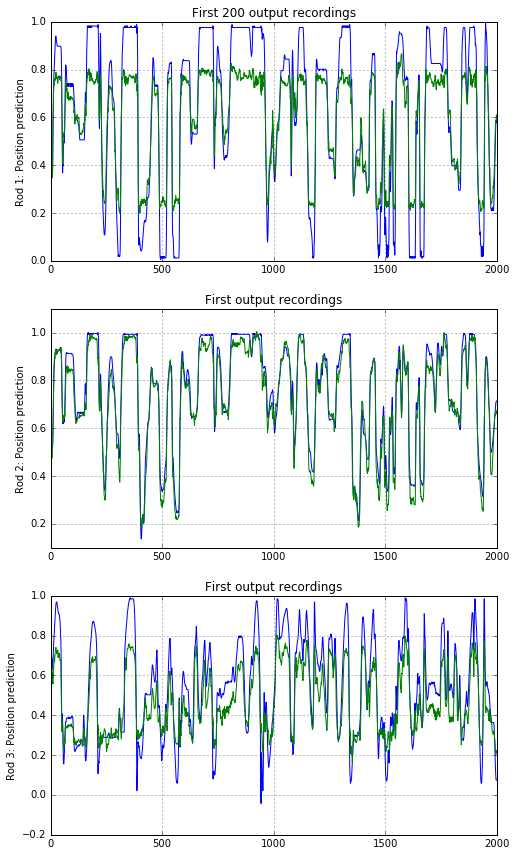

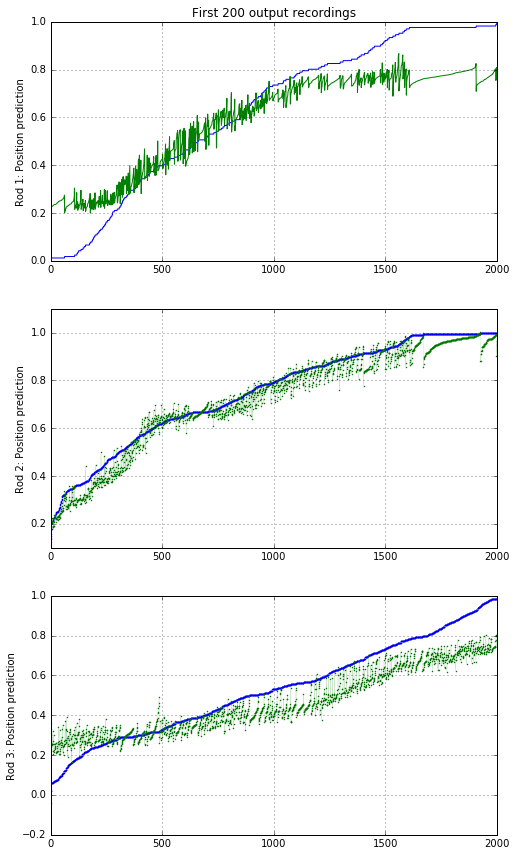

In [13]:
# Plot the real versus predicted values for some of the validation data
(frames, outputs_true) = next(ValidateBatchGen(2000))
plot_validate(model, frames, outputs_true, "Position prediction")

# Transfer the model as a base to predict the future change in rod positions
The theory is that the model has designed filters that are able to successfully extract the rod positions. This is important information needed to make a good decision on how the rods should be moved. We take this base model which has learned how to track the rod positions as a base for the real AI that predicts the rod movements that are going to occur next.


In [4]:
# Load the best position prediction model as the starting point
epoch = 10
WEIGHTS_FNAME = 'pos_cnn_weights_%i.hdf'
model.load_weights(WEIGHTS_FNAME % epoch)
print("Loaded model.")



Loaded model.


In [8]:
def mse(y_true, y_pred):
    return K.square(y_pred - y_true)*0.001 # Hackjob so Keras iterations show exponential value of MSE to get precision.


model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00001),
              loss='mean_squared_error',
              metrics=[mse])

print("Updated learner.")

# Train the model to predict the future position. This is the control signal to the robot AI
WEIGHTS_FNAME = 'dpos_cnn_weights_%i.hdf'
MODELS_FNAME = 'dpos_cnn_models_%i.h5'
for epoch in range(10000):
    try:
        model.fit_generator(TrainBatchGenDpos(20), 1552, epochs=1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGenDpos(20), validation_steps = 500, pickle_safe=False, initial_epoch=epoch)
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + MODELS_FNAME )  % epoch)
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        break
    

Updated learner.
Epoch 1/1
   5/1552 [..............................] - ETA: 4251s - loss: 0.0745 - mse: 7.4452e-05
User stopped the training.


Loaded model.
2000/2000 [==============================] - 17s    
Predicted.
array([[ 0.13855422,  0.03623188,  0.06417112],
       [ 0.22289157,  0.09057971,  0.09625668],
       [ 0.30722892,  0.15579709,  0.11229946],
       ..., 
       [-0.07228915,  0.03985507,  0.        ],
       [-0.06626506,  0.04710145,  0.        ],
       [-0.06024097,  0.04347826,  0.        ]], dtype=float32)
array([[ 0.50100255,  0.49753293,  0.49612364],
       [ 0.50339562,  0.50341928,  0.49956062],
       [ 0.50173658,  0.49948627,  0.49966088],
       ..., 
       [ 0.50564641,  0.5077194 ,  0.4992635 ],
       [ 0.49996799,  0.49850711,  0.49659455],
       [ 0.49680814,  0.49210778,  0.49362361]], dtype=float32)


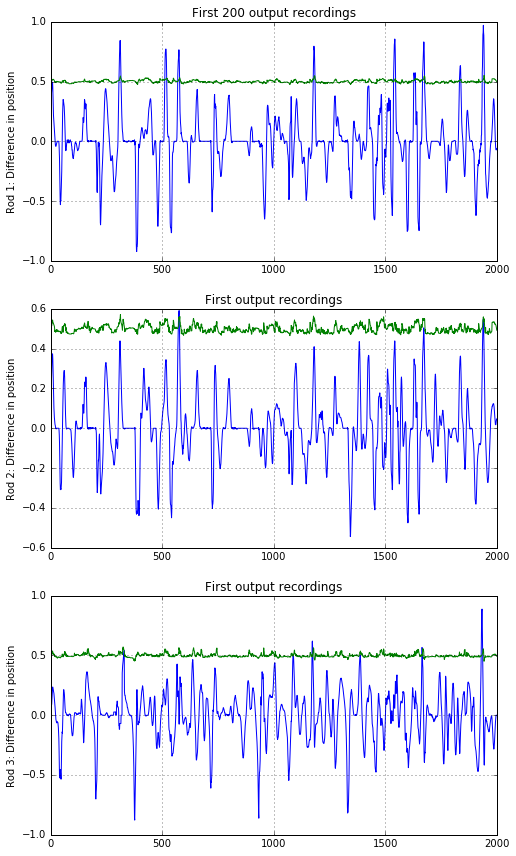

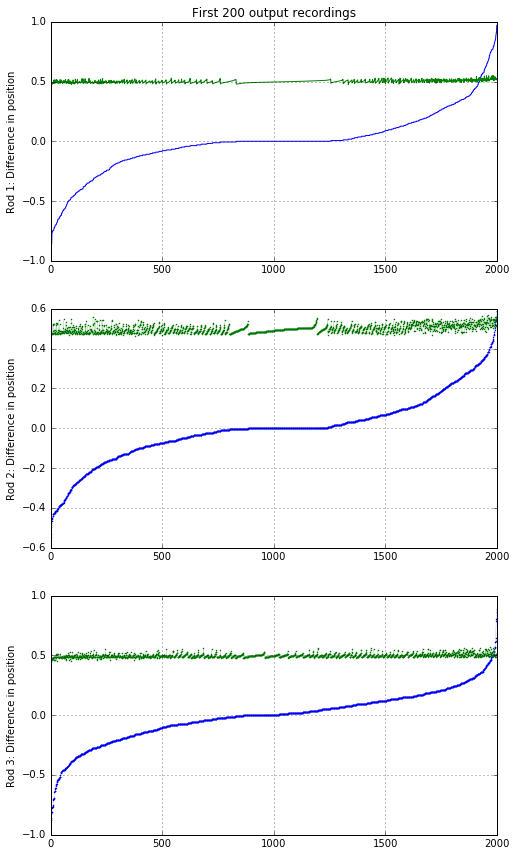

In [18]:
# Load the best position prediction model as the starting point
epoch = 90
WEIGHTS_FNAME = 'dpos_cnn_weights_%i.hdf'
model.load_weights(WEIGHTS_FNAME % epoch)
print("Loaded model.")


# Plot the real versus predicted values for some of the validation data
(frames, outputs_true) = next(ValidateBatchGenDpos(2000))
plot_validate(model, frames, outputs_true, "Difference in position")

In [7]:
# Load the best position prediction model as the starting point
epoch = 2
WEIGHTS_FNAME = 'dpos_cnn_weights_%i.hdf'
model.load_weights(WEIGHTS_FNAME % epoch)
print("Loaded model.")

def mse(y_true, y_pred):
    return K.square(y_pred - y_true)*0.001 # Hackjob so Keras iterations show exponential value of MSE to get precision.

# Continue at a lower learning rate
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0000005),
              loss='mean_squared_error',
              metrics=[mse])

print("Updated learner.")

# Train the model to predict the future position. This is the control signal to the robot AI
WEIGHTS_FNAME = 'dpos2_cnn_weights_%i.hdf'
MODELS_FNAME = 'dpos2_cnn_models_%i.h5'
for epoch in range(10000):
    print("------ Epoch %i -------" % epoch)
    model.fit_generator(TrainBatchGenDpos(20), 1552, epochs=1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGenDpos(20), validation_steps = 500, pickle_safe=False, initial_epoch=0)
    #model.fit_generator(TrainBatchGen(20), 1552, epochs=1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(20), validation_steps = 500, pickle_safe=False, initial_epoch=0)
    model.save_weights(WEIGHTS_FNAME % epoch)
    model.save(MODELS_FNAME % epoch)

Loaded model.
Updated learner.
------ Epoch 0 -------
Epoch 1/1
1552/1552 [==============================] - 919s - loss: 0.0056 - mse: 5.6425e-06 - val_loss: 0.0033 - val_mse: 3.3079e-06
------ Epoch 1 -------
Epoch 1/1
1552/1552 [==============================] - 911s - loss: 0.0037 - mse: 3.7309e-06 - val_loss: 0.0033 - val_mse: 3.3077e-06
------ Epoch 2 -------
Epoch 1/1
1552/1552 [==============================] - 911s - loss: 0.0033 - mse: 3.2630e-06 - val_loss: 0.0033 - val_mse: 3.3074e-06
------ Epoch 3 -------
Epoch 1/1
1552/1552 [==============================] - 911s - loss: 0.0033 - mse: 3.3073e-06 - val_loss: 0.0033 - val_mse: 3.3071e-06
------ Epoch 4 -------
Epoch 1/1
1552/1552 [==============================] - 910s - loss: 0.0033 - mse: 3.3130e-06 - val_loss: 0.0033 - val_mse: 3.3068e-06
------ Epoch 5 -------
Epoch 1/1
1552/1552 [==============================] - 911s - loss: 0.0033 - mse: 3.3101e-06 - val_loss: 0.0033 - val_mse: 3.3066e-06
------ Epoch 6 -------
Epoc

KeyboardInterrupt: 

In [9]:
# Continue at a lower learning rate
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00000005),
              loss='mean_squared_error',
              metrics=[mse])

print("Updated learner.")

# Train the model to predict the future position. This is the control signal to the robot AI
WEIGHTS_FNAME = 'dpos2_cnn_weights_%i.hdf'
MODELS_FNAME = 'dpos2_cnn_models_%i.h5'
for epoch in range(10000):
    print("------ Epoch %i -------" % epoch)
    model.fit_generator(TrainBatchGenDpos(20), 1552, epochs=1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGenDpos(20), validation_steps = 500, pickle_safe=False, initial_epoch=0)
    #model.fit_generator(TrainBatchGen(20), 1552, epochs=1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(20), validation_steps = 500, pickle_safe=False, initial_epoch=0)
    model.save_weights(WEIGHTS_FNAME % epoch)
    model.save(MODELS_FNAME % epoch)

Updated learner.
------ Epoch 0 -------
Epoch 1/1
   2/1552 [..............................] - ETA: 4689s - loss: 5.5276e-06 - mse: 5.5276e-09

KeyboardInterrupt: 